<center>
<img src="https://telegra.ph/file/76c3a3888f46b2faf76b5.jpg" width="400"> 
</center>


#  Максимально правдоподобный семинар

In [1]:
import numpy as np
import pandas as pd

from scipy import stats 
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Фрекен Бок

[Как известно](https://www.livelib.ru/quote/305456-malysh-i-karlson-kotoryj-zhivet-na-kryshe-astrid-lindgren), Фрекен Бок пьёт коньяк по утрам. У нас даже есть дневные данные (в граммах):

In [2]:
x = [3.2, 7.9, 5.4, 4.9, 6.2, 4.3]

__а)__ Предполагая, что $x_i$ независимы и нормальны $N(\mu, \sigma^2)$ выпишем функцию правдоподобия.


$$
f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$$




$$
L(\mu, \sigma^2 \mid x_1, \ldots, x_n) =  \frac{1}{(2 \pi \sigma^2)^{\frac{n}{2}}} \cdot e^{- \sum_{i=1}^n \frac{(x_i - \mu)^2}{2 \sigma^2}}
$$

$$
\ln L(\mu, \sigma^2 \mid x_1, \ldots, x_n) \propto  -0.5 \cdot n \cdot \ln  \sigma^2 - \sum_{i=1}^n \frac{(x_i - \mu)^2}{2 \sigma^2} \to \max_{\mu, \sigma^2}
$$

$\propto$ - равенство с точностью до константы

Чтобы гарантировать положительность параметра $\sigma^2$ функция у нас будет зависеть от вектора параметров $\theta$, причем $\theta_1 = \mu$, а $\theta_2 = \ln \sigma^2$.

Реализуйте функцию правдоподобия.

In [3]:
def lnL(theta, x):
    mu = theta[0]
    s2 = np.exp(theta[1])
    
    x =np.array(x)
    n = x.size
    
    l = -0.5*n*np.log(s2) - 0.5/s2*np.sum((x-mu)**2)
    return -l
    
lnL([4, 0.2], x)

10.240554617493236

__б)__ Оцените неизвестные параметры с помощью метода `minimize` из `scipy.optimize`

In [4]:
theta_init = [0, 0]
res = minimize(lnL, theta_init, args=x)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.353606615954105
        x: [ 5.317e+00  7.845e-01]
      nit: 14
      jac: [-1.907e-06  2.146e-06]
 hess_inv: [[ 3.527e-01  1.299e-02]
            [ 1.299e-02  3.198e-01]]
     nfev: 51
     njev: 17

In [5]:
mu, s2 = res.x
s2 = np.sqrt(np.exp(s2))
mu, s2

(5.31666598766134, 1.480334589652924)

__в)__ Получите тот же результат используя встроенный метод `stats.norm.fit`:

In [6]:
mu, s = stats.norm.fit(x)
mu, s

(5.316666666666666, 1.4803340463857775)

__г)__ Постройте $95\%$ доверительный интервал для $\mu$

In [7]:
res.hess_inv

array([[0.35266917, 0.0129928 ],
       [0.0129928 , 0.31977249]])

In [8]:
np.var(x)/len(x)

0.3652314814814815

In [9]:
alpha = 0.05
z = stats.norm().ppf(1 - alpha/2)

left = res.x[0] - z*np.sqrt(res.hess_inv[0,0])
right = res.x[0] + z*np.sqrt(res.hess_inv[0,0])

print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))

Доверительный интервал [4.153; 6.481] ширины 2.328


__д)__ Проверьте гипотезу о том, что $\mu = 1$ с помощью теста отношения правдоподобий. 

In [10]:
def lnL_r(theta, x):
    mu = 1
    s2 = np.exp(theta)
    
    x =np.array(x)
    n = x.size
    
    l = -0.5*n*np.log(s2) - 0.5/s2*np.sum((x-mu)**2)
    return -l
    
lnL_r(0.2, x)

51.75020379854693

In [11]:
theta_init = 0
res_r = minimize(lnL_r, theta_init, args=x)
res_r

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.108462564158728
        x: [ 3.036e+00]
      nit: 9
      jac: [-2.384e-07]
 hess_inv: [[ 3.328e-01]]
     nfev: 20
     njev: 10

In [12]:
lnL_r = res_r.fun
lnL_ur = res.fun

In [13]:
2*(lnL_r - lnL_ur)

13.509711896409247

In [14]:
stats.chi2(df=1).ppf(0.95)

3.841458820694124

Гипотеза отвергается! 

__е)__ Проверьте гипотезу о том, что $\mu = 1$, а $\sigma^2 = 2$ с помощью теста отношения правдоподобий.

In [15]:
lnL_ur = res.fun
lnL_r = lnL([5,2.5], x)

In [16]:
2*(lnL_r - lnL_ur)

5.421455499170399

In [17]:
stats.chi2(df=2).ppf(0.95)

5.991464547107979

Гипотеза отвергается. 

# 2.  Пуассоновские призраки

<br>

<center>
<img src="https://pbs.twimg.com/media/DqWmCg9X4AAkl0n.jpg" height="200" width="350"> 
</center>

А ещё Фрекен-Бок иногда видит привидения! Данные по количеству привидений у нас тоже есть :)

In [18]:
y =  [1, 2, 0, 0, 2, 0]

Предположим, что количество привидений имеет пуассоновское распределение с параметром $\lambda$. 

__а)__ Оцените $\lambda$ с помощью ММП:

Вероятность, что случайная величина $X$ примет значение $k$: 

$$
\mathbb{P}(X = k) = \frac{e^{-\lambda} \cdot \lambda^k}{k!}
$$

$$
L(\lambda \mid x_1, \ldots x_n) = \frac{e^{-\lambda} \cdot \lambda^{
x_1}}{x_1!} \cdot \ldots \cdot \frac{e^{-\lambda} \cdot \lambda^{x_n}}{x_n!}
$$

$$
\ln L(\lambda \mid x_1, \ldots x_n) = \cdot n + \ln \lambda \cdot \sum_{i=1}^n x_i - \sum_{i=1}^n x_i!  \propto - \lambda \cdot n + \ln \lambda \cdot \sum_{i=1}^n x_i \to \max_{\lambda}
$$

$\propto$ - равенство с точностью до константы


$$
\ln L(\lambda \mid x_1, \ldots x_n)  \propto  \sum_{i=1}^n [- \lambda + \ln \lambda \cdot x_i] \to \max_{\lambda}
$$

In [19]:
def lnL(theta, y):
    rate = np.exp(theta)
    y = np.array(y)
    l = -rate + np.log(rate)*y
    return -1*np.sum(l)

lnL(4, y)

307.5889001988654

In [20]:
theta_init = 0
res = minimize(lnL, theta_init, args=y)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.91160778397651
        x: [-1.823e-01]
      nit: 3
      jac: [ 8.345e-06]
 hess_inv: [[ 2.007e-01]]
     nfev: 10
     njev: 5

Предположим, что в $i$-й день интенсивность пуассоновского распределения $\lambda_i$ связана с количеством выпитого коньяка формулой $\lambda_i = e^{a + b \cdot x_i}$. То есть, возможно, что Фрекен Бок видит призраков из-за коньяка. 

__б)__ Оцените параметры $a$ и $b$, выписав функцию правдоподобия. 

$$
\ln L(\lambda \mid x_1, \ldots x_n)  \propto  \sum_{i=1}^n [- \lambda_i + \ln \lambda_i \cdot x_i] \to \max_{a, b}
$$

$$
\lambda_i = \exp(a + b y_i)
$$

In [21]:
fbock = pd.DataFrame({
    'x': [3.2, 7.9, 5.4, 4.9, 6.2, 4.3], 
    'y': [1, 2, 0, 0, 2, 0]
})

In [22]:
def lnL(theta, fbock):
    x = np.array(fbock['x'])
    y = np.array(fbock['y'])
    
    a = theta[0]
    b = theta[1]

    rate = np.exp(a + b*x)
    l = -rate + np.log(rate)*y
    return -1*np.sum(l)

lnL([1,2], fbock)

20635012.00334143

In [23]:
theta_init = [0,0]
res = minimize(lnL, theta_init, args=fbock)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.901374802427501
        x: [-2.599e+00  4.170e-01]
      nit: 9
      jac: [ 5.960e-08  1.192e-07]
 hess_inv: [[ 3.642e+00 -5.478e-01]
            [-5.478e-01  8.718e-02]]
     nfev: 39
     njev: 13

__в)__ Постройте прогнозы для парметра лямбда при разном объёме выпитого коньяка.

In [24]:
x_test = np.array([1, 2])
lam_hat = np.exp(res.x[0] + res.x[1]*x_test)
lam_hat

array([0.1128355 , 0.17121004])

In [25]:
# ФБ увидит 1 призрака 
np.exp(-lam_hat)*lam_hat

array([0.10079568, 0.14426921])

По аналогии можем вычислить все интересующие нас вероятности. 

__в)__  Данная модель является довольно популярной и реализована в `statsmodels`. Она называется Пуассоновской регрессией. Оценим её встроенными методами. 

In [26]:
!pip install statsmodels


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [27]:
import statsmodels.formula.api as smf

In [28]:
model = smf.poisson(data=fbock, formula="y ~ 1 + x")
model.fit().summary()

Optimization terminated successfully.
         Current function value: 1.047945
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                    6
Model:                        Poisson   Df Residuals:                        4
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 May 2023   Pseudo R-squ.:                  0.1384
Time:                        23:12:17   Log-Likelihood:                -6.2877
converged:                       True   LL-Null:                       -7.2979
Covariance Type:            nonrobust   LLR p-value:                    0.1552
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5988      1.918     -1.355      0.175      -6.358       1.161
x              0.4170      0.297      1.404      0.160      -0.165       0.999
==============================================================================
"""

__г)__ C помощью полученного протокола, проверим гипотезу о взаимосвязи призраков и выпитого коньяка.

- Точечная оценка коэффицента перед коньяком равна $0.4170$. ММП даёт нам асимптотически нормальные оценки, то есть мы можем для проверки гипотез для коэффициента использовать $z-$тест. 
- В колонке $z$ посчитана статистика для гипотезы о равенстве коэффициента нулю (гипотеза о значимости коэффициента). Она оказалась равна $1.404$. Также для неё найдено p_value, оно оказалось равно $0.160$. То есть гипотеза о равенстве коэффициента нулю не отвергается. 

> Если все наши предпосылки выполнены и данные действительно имеют распределение Пуассона, коньяк никак не влияет на число увиденных приведений. 


# 3. Логистические призраки

Предположим другую вероятностную модель. Теперь мы будем предполагать, что сам факт обнаружения хотя бы одного приведения, имеет вероятность $p_i$, зависящую от $y_i$:

$$
p_i = \exp(a + b y_i) / (1 + \exp(a + b y_i))
$$

__а)__ Введите дамми-переменную равную 1, если Фрекен Бок видела приведение:

In [29]:
fbock['atleast1'] = 1 * (fbock['y'] > 0)
fbock

,x,y,atleast1
0,3.2,1,1
1,7.9,2,1
2,5.4,0,0
3,4.9,0,0
4,6.2,2,1
5,4.3,0,0


__б)__ Определив лапками функцию правдоподобия, оцените $a$ и $b$:

In [30]:
def minus_lklh(theta, fbock):
    a, b = theta # распакуем параметры для читабельности
    p = np.exp(a + b * fbock['x']) / (1 + np.exp(a + b * fbock['x']))
    log_probs = fbock['atleast1'] * np.log(p) + (1 - fbock['atleast1']) * np.log(1 - p)
    lklh = np.sum(log_probs)
    return -lklh

theta_init = [0, 0]

optim_res = minimize(minus_lklh, theta_init, args=fbock)
optim_res.fun, optim_res.x

(3.8709632618131784, array([-2.35157571,  0.44383852]))

__в)__ Оцените $a$ и $b$ с помощью `statsmodels`. Нужная модель называется `logit`.

In [31]:
smf.logit(data=fbock, formula='atleast1 ~ 1 + x').fit().summary()

Optimization terminated successfully.
         Current function value: 0.645161
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               atleast1   No. Observations:                    6
Model:                          Logit   Df Residuals:                        4
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 May 2023   Pseudo R-squ.:                 0.06923
Time:                        23:12:17   Log-Likelihood:                -3.8710
converged:                       True   LL-Null:                       -4.1589
Covariance Type:            nonrobust   LLR p-value:                    0.4479
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3516      3.376     -0.697      0.486      -8.969       4.266
x              0.4438      0.620      0.716      0.474      -0.772       1.660
==============================================================================
"""

Это ровно та же логистическая регрессия, что и в sklearn, но акцент в модели делается на проверке гипотез, а не на прогнозировании. 

> Тут семинарист затрёт вам глубокую философскую тираду про BVD, прогнозы и интерпретацию. Глубже узнать об этом он вас позовёт на ИАД или МО-1 :)

# 4. Немного про оптимизацию

__а)__ Найдите минимум фукнции $f(x_1, x_2) = (x_1 - 2)^2 + (x_2 - 4)^2$

In [32]:
def fun(x):
    """ какая-то приятная функция """
    z = (x[0] - 2) ** 2 + (x[1] - 4) ** 2
    return z

x_init = [0, 0]
optim_res = minimize(fun, x_init)
optim_res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.095763293783874e-17
        x: [ 2.000e+00  4.000e+00]
      nit: 3
      jac: [ 6.371e-09 -2.159e-09]
 hess_inv: [[ 9.000e-01 -2.000e-01]
            [-2.000e-01  6.000e-01]]
     nfev: 12
     njev: 4

In [33]:
optim_res.x, optim_res.fun

(array([2.        , 3.99999999]), 9.095763293783874e-17)

Теперь добавим в функцию параметр $a$: $f(x_1, x_2) = (x_1 - 2a)^2 + (x_2 - 4)^2$

__б)__ Найдите экстремум функции при $a=4$ и при $a=10$.

In [34]:
def fun(x, a=1):
    """ какая-то приятная функция """
    z = (x[0] - 2 * a) ** 2 + (x[1] - 4) ** 2
    return z

x_init = [0, 0]
optim_res = minimize(fun, x_init, args=4)
optim_res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.608215111971474e-12
        x: [ 8.000e+00  4.000e+00]
      nit: 4
      jac: [-2.263e-06  4.624e-06]
 hess_inv: [[ 6.000e-01 -2.000e-01]
            [-2.000e-01  9.000e-01]]
     nfev: 15
     njev: 5

In [35]:
optim_res = minimize(fun, x_init, args=10)
optim_res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.3881933437907206e-11
        x: [ 2.000e+01  4.000e+00]
      nit: 3
      jac: [ 2.142e-06 -9.525e-06]
 hess_inv: [[ 5.192e-01 -9.615e-02]
            [-9.615e-02  9.808e-01]]
     nfev: 15
     njev: 5

Но иногда встречаются функции-бяки :)

$f(x_1, x_2, x_3) = 0.01 (x_1 - 0.5)^2 + |x_1^2 - x_2| + |x_1^2 - x_3|$

__в)__ найдите минимум этой функции устно

__г*)__ найдите минимум этой функции с помощью `minimize` (автор задачи тоже не знает решения)

In [36]:
def byaka(x):
    """ известная неприятная функция """
    z = 0.01 * (x[0] - 0.5) ** 2 + abs(x[0] ** 2 - x[1]) + abs(x[0] ** 2 - x[2])
    return z

x_init = [0, 0, 0]
optim_res = minimize(byaka, x_init, method='powell')
optim_res = minimize(byaka, x_init, method='bfgs')
optim_res = minimize(byaka, x_init, method='nelder-mead')
optim_res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0022029130300699013
             x: [ 3.078e-02  9.461e-04  9.473e-04]
           nit: 161
          nfev: 280
 final_simplex: (array([[ 3.078e-02,  9.461e-04,  9.473e-04],
                       [ 3.071e-02,  9.423e-04,  9.429e-04],
                       [ 3.071e-02,  9.421e-04,  9.429e-04],
                       [ 3.087e-02,  9.508e-04,  9.532e-04]]), array([ 2.203e-03,  2.203e-03,  2.203e-03,  2.203e-03]))

__д)__ нарисуйте хорошую функцию :)

In [37]:
x = np.arange(-5, 5, 0.25)
y = np.arange(-5, 5, 0.25)
x_mesh, y_mesh = np.meshgrid(x, y)
xy = np.array([x_mesh, y_mesh]).reshape(2, len(x) * len(y)).T
xy

array([[-5.  , -5.  ],
       [-4.75, -5.  ],
       [-4.5 , -5.  ],
       ...,
       [ 4.25,  4.75],
       [ 4.5 ,  4.75],
       [ 4.75,  4.75]])

In [38]:
xy = np.array([x_mesh, y_mesh]).reshape(2, len(x) * len(y)).T
z = np.apply_along_axis(fun, 1, xy)
z

array([130.    , 126.5625, 123.25  , ...,   5.625 ,   6.8125,   8.125 ])

In [39]:
z_mesh = z.reshape(x_mesh.shape[0], -1)

In [40]:
z_mesh.shape

(40, 40)

Text(0.5, 1.0, 'Линии уровня функции fun')

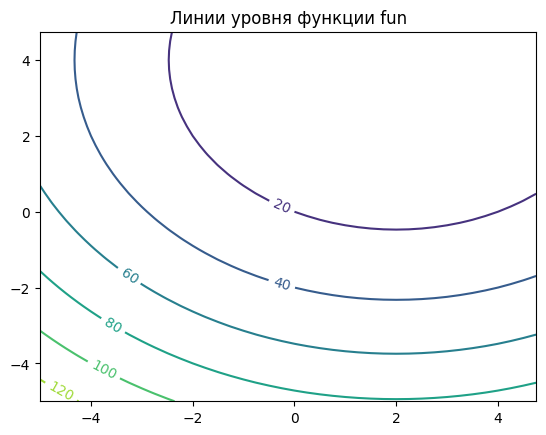

In [41]:
fig, ax = plt.subplots()
contour = ax.contour(x_mesh, y_mesh, z_mesh)
ax.clabel(contour, inline=1, fontsize=10)
ax.set_title('Линии уровня функции fun')